# Lung‑CT Notebook Map

**Goal:** pick the best lung‑X‑ray classifier by testing three fine‑tuning strategies on 5‑class and 2‑class tasks.

1. **Setup:** imports, mixed‑precision, `trim_ram()` helper.  
2. **Data:** load metadata (`dataset_lung.xlsx`) + two image packs  
   * **Full 5** (`full5_mix.npz`) *5 classes*  
   * **Full 2** (`full2_trad.npz`) *binary*  
   * **Nodule 5** (`nod5_mix.npz`) *5-class nodule-focused crops*  
   * **Nodule 2** (`nod2_trad.npz`) *binary nodule-focused crops*  

3. **EDA:** sample‑image grids and class‑balance bar charts.  
4. **Model utils:**  
   * ConvNeXt‑Tiny + custom dense head builder  
   * `train_multi_stage()` = head‑training → progressive unfreeze, linear LR decay  
   * Callback logs **balanced acc, F1‑w, AUPRC‑w** and stores best weights.  
5. **Modes tested:**
   - **Conservative:** slow unfreeze, LR 5e-5 → 5e-6  
   - **Moderate:** mid-speed unfreeze, LR 5e-4 → 5e-5  
   - **Aggressive:** one-shot 90 % unfreeze, LR 1e-3 → 1e-4
6. **Evaluation:** unified routine prints metrics table, learning curves, confusion matrix & per‑class F1; best‑AUPRC model and full training history are saved.


## Initialize environment
imports, memory cleanup utility, and mixed precision policy

In [ ]:
import os
import gc
import random
import ctypes
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, mixed_precision
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input as preprocess_convnext
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, average_precision_score,
    precision_recall_curve, auc
)

from scipy import stats

def trim_ram():
    libc = ctypes.CDLL("libc.so.6")
    result = libc.malloc_trim(0)
    tf.keras.backend.clear_session()
    plt.close('all')
    gc.collect()
    print("malloc_trim result:", result)

mixed_precision.set_global_policy("mixed_float16")

2025-05-08 09:18:49.696516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746695929.918009      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746695929.981226      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Data
### Load Excel File

In [ ]:
file_path = '/kaggle/input/dataset_lung.xlsx'
df = pd.read_excel(file_path)
print(df)
print("File Shape:", df.shape)

                  Full_slice               Nodule  TumorClass
0        pat1_fullslice.nrrd     pat1_nodule.nrrd           5
1        pat2_fullslice.nrrd     pat2_nodule.nrrd           5
2        pat3_fullslice.nrrd     pat3_nodule.nrrd           2
3        pat4_fullslice.nrrd     pat4_nodule.nrrd           5
4        pat5_fullslice.nrrd     pat5_nodule.nrrd           4
...                      ...                  ...         ...
2358  pat2368_fullslice.nrrd  pat2368_nodule.nrrd           2
2359  pat2369_fullslice.nrrd  pat2369_nodule.nrrd           2
2360  pat2387_fullslice.nrrd  pat2387_nodule.nrrd           5
2361  pat2399_fullslice.nrrd  pat2399_nodule.nrrd           5
2362  pat2415_fullslice.nrrd  pat2415_nodule.nrrd           5

[2363 rows x 3 columns]
File Shape: (2363, 3)


### Load Images

In [ ]:
def load_print_merge(npz_path, mode):
    data = np.load(npz_path)
    print(f"Shapes of {mode}:")
    for key, arr in data.items():
        print(f"  {key}: {arr.shape}")
    return (
        data['X_train'], data['y_train'],
        data['X_val'],   data['y_val'],
        data['X_test'],  data['y_test']
    )

X_train_5, y_train_5, X_val_5, y_val_5, X_test_5, y_test_5 = load_print_merge(
    '/kaggle/input/full5_mix.npz', 'Full5'
)
X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, y_test_2 = load_print_merge(
    '/kaggle/input/full2_trad.npz', 'Full2'
)

Shapes of Full5:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Full2:
  X_train: (2866, 224, 224)
  y_train: (2866,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)


In [ ]:
#load nodule data
X_train, y_train, X_val, y_val, X_test, y_test = load_print_merge('/kaggle/input/ai-in-biomed-dataset-lung/nod5_mix.npz')

Original shapes:
  X_train: (3815, 224, 224)
  y_train: (3815,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (473, 224, 224)
  y_test: (473,)

After merging train + val:
  X_train: (3815, 224, 224)
  y_train: (3815,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test : (473, 224, 224)
  y_test : (473,)


## Visualize Data
### Plot Images
Visualize one sample image per class for each dataset split

Full5 Images:


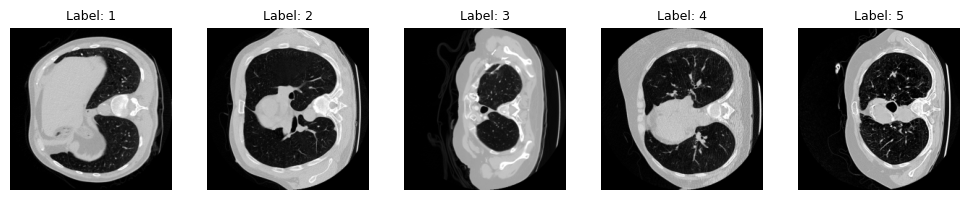

Full2 Images:


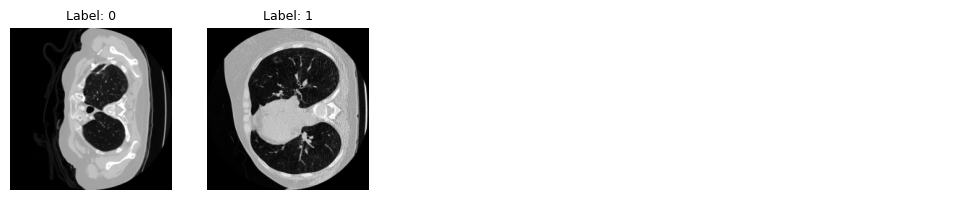

In [ ]:
def plot_one_per_class(X, y, names=None, cols=None, figsize=(8, 4)):
    classes = np.unique(y)
    n = len(classes)
    cols = cols or n
    rows = ceil(n / cols)
    mapping = {lbl: names[i] for i, lbl in enumerate(classes)} if names and len(names) == n else {}

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, lbl in zip(axes.flatten(), classes):
        img = X[y == lbl][0]
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(f"Label: {mapping.get(lbl, lbl)}", fontsize=9)
        ax.axis('off')

    for ax in axes.flatten()[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("Full5 Images:")
plot_one_per_class(X_train_5, y_train_5, figsize=(10, 2), cols=5)

print("Full2 Images:")
plot_one_per_class(X_train_2, y_train_2, figsize=(10, 2), cols=5)

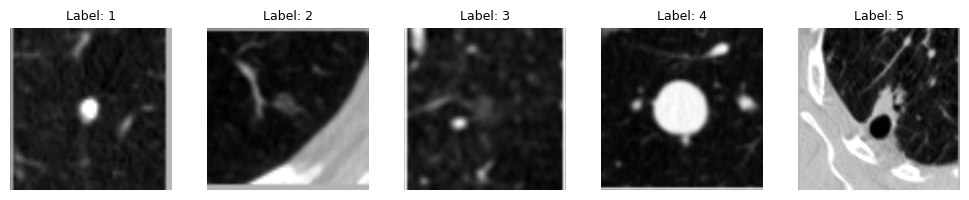

In [ ]:
#nodule
plot_one_per_class(X_train, y_train, figsize=(10, 2), cols=5)

### Data Info
Display min/max values and label distribution for each dataset split

In [ ]:
def show_data_info(X, y, X_name='X', y_name='y'):
    mn, mx = np.min(X), np.max(X)
    print(f"{X_name} → min = {mn:.4f}, max = {mx:.4f}")
    print(f"Unique values in {y_name}: {np.unique(y)}")

def display_info(X_train, y_train, X_val, y_val, X_test, y_test, mode):
    print(f"\n{mode} data information:")
    show_data_info(X_train, y_train, X_name='X_train', y_name='y_train')
    show_data_info(X_val,   y_val,   X_name='X_val',   y_name='y_val')
    show_data_info(X_test,  y_test,  X_name='X_test',  y_name='y_test')

display_info(X_train_5, y_train_5, X_val_5, y_val_5, X_test_5, y_test_5, "Full5")
display_info(X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, y_test_2, "Full2")


Full5 data information:
X_train → min = -2.5038, max = 3.1569
Unique values in y_train: [1 2 3 4 5]
X_val → min = -1.7609, max = 2.8044
Unique values in y_val: [1 2 3 4 5]
X_test → min = -1.6253, max = 2.7693
Unique values in y_test: [1 2 3 4 5]

Full2 data information:
X_train → min = -2.5038, max = 3.1569
Unique values in y_train: [0 1]
X_val → min = -1.7609, max = 2.8044
Unique values in y_val: [0 1]
X_test → min = -1.6253, max = 2.7693
Unique values in y_test: [0 1]


## Class Distribution
### Merged
Plot class distribution for training, validation, and test sets

Full5:


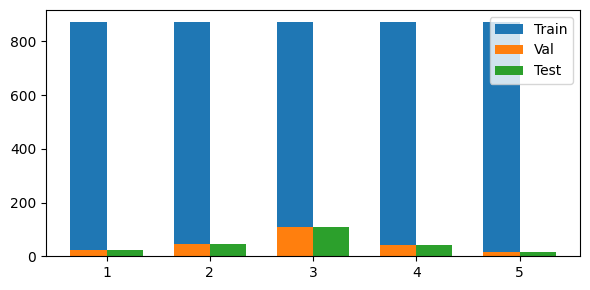

Full2:


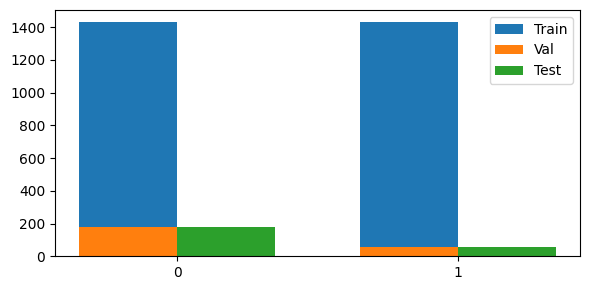

In [ ]:
def plot_class_distribution(y_train, y_val, y_test, names=None, figsize=(8, 4)):
    classes = np.unique(np.concatenate([y_train, y_val, y_test]))
    train_counts = [np.sum(y_train == c) for c in classes]
    val_counts   = [np.sum(y_val   == c) for c in classes]
    test_counts  = [np.sum(y_test  == c) for c in classes]
    labels = names if names and len(names) == len(classes) else [str(c) for c in classes]
    x = np.arange(len(classes))
    w = 0.35

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x - w/2, train_counts, w, label='Train')
    ax.bar(x - w/2, val_counts,   w, label='Val')
    ax.bar(x + w/2, test_counts,  w, label='Test')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

print("Full5:")
plot_class_distribution(y_train_5, y_val_5, y_test_5, figsize=(6, 3))

print("Full2:")
plot_class_distribution(y_train_2, y_val_2, y_test_2, figsize=(6, 3))

### Separately
Plot separate class distributions for train, validation, and test sets

Full5:


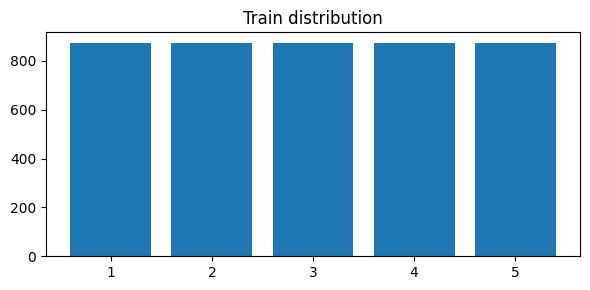

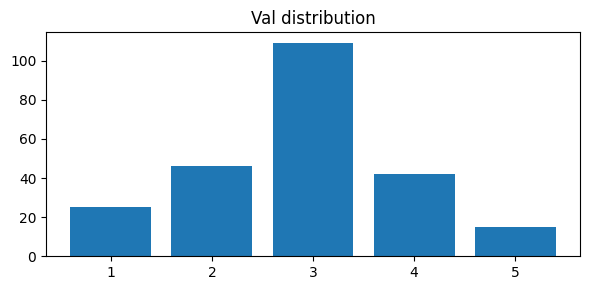

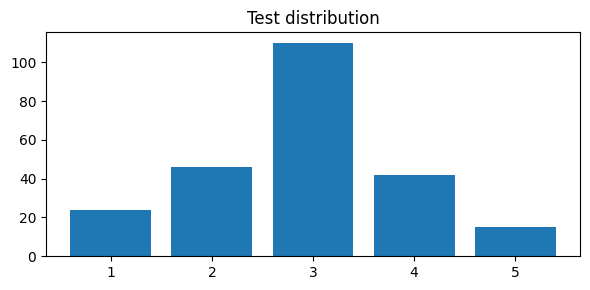

Full2:


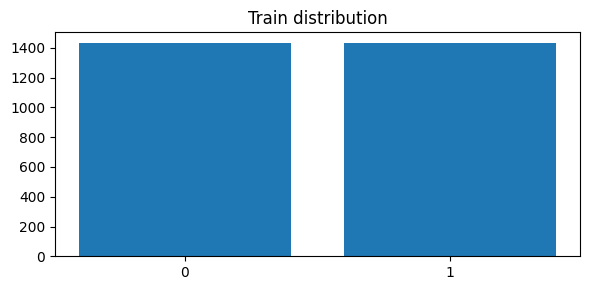

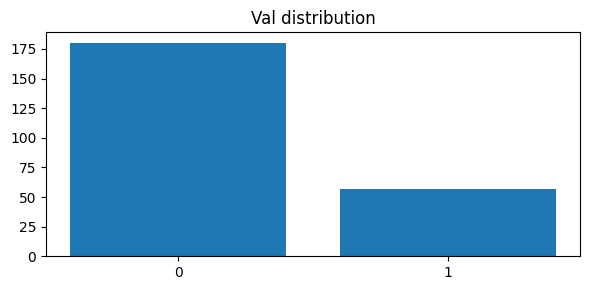

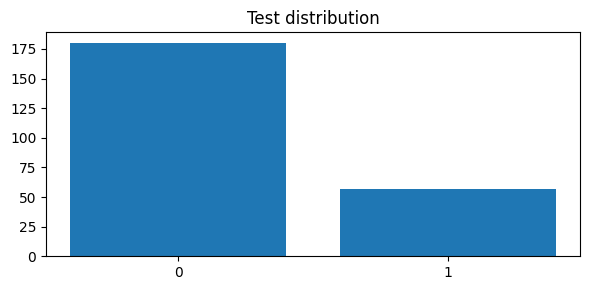

In [ ]:
def _plot_dist(y, names, title, figsize):
    classes, counts = np.unique(y, return_counts=True)
    labels = names if names and len(names) == len(classes) else [str(c) for c in classes]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(labels, counts)
    ax.set_title(f'{title} distribution')
    plt.tight_layout()
    plt.show()

def plot_class_distributions_sep(y_train, y_val, y_test, names=None, figsize=(6, 3)):
    _plot_dist(y_train, names, 'Train', figsize)
    _plot_dist(y_val,   names, 'Val',   figsize)
    _plot_dist(y_test,  names, 'Test',  figsize)

print("Full5:")
plot_class_distributions_sep(y_train_5, y_val_5, y_test_5, figsize=(6, 3))

print("Full2:")
plot_class_distributions_sep(y_train_2, y_val_2, y_test_2, figsize=(6, 3))

## Model Functions
Define validation metrics callback and multi-stage ConvNeXt training utilities

In [ ]:
class ValidationMetrics(callbacks.Callback):
    def __init__(self, val_dataset):
        super().__init__()
        self.val_ds = val_dataset
        self.history = {
            'val_balanced_accuracy': [],
            'val_f1_score': [],
            'val_weighted_auprc': []
        }
        self.best_val_weighted_auprc = -np.inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for x_batch, y_batch in self.val_ds:
            preds = self.model.predict(x_batch, verbose=0)
            y_true.append(y_batch.numpy())
            y_pred.append(preds)
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)

        bal_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
        f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
        auprc_w = average_precision_score(y_true, y_pred, average='weighted')

        logs = logs or {}
        logs.update({
            'val_balanced_accuracy': bal_acc,
            'val_f1_score': f1,
            'val_weighted_auprc': auprc_w
        })

        self.history['val_balanced_accuracy'].append(bal_acc)
        self.history['val_f1_score'].append(f1)
        self.history['val_weighted_auprc'].append(auprc_w)

        print(f" — val_balanced_accuracy: {bal_acc:.4f}"
              f" — val_f1_score: {f1:.4f}"
              f" — val_weighted_auprc: {auprc_w:.4f}")

        if auprc_w > self.best_val_weighted_auprc:
            self.best_val_weighted_auprc = auprc_w
            self.best_weights = self.model.get_weights()


def build_convnext_classifier(input_shape=(224, 224, 3), num_classes=5,
                              dropout=0.5, head_layers=None):
    base = ConvNeXtTiny(include_top=False, weights='imagenet',
                        input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(dropout)(x)

    head_layers = head_layers or [num_classes]
    for i, units in enumerate(head_layers):
        activation = 'softmax' if i == len(head_layers) - 1 else 'relu'
        x = layers.Dense(units, activation=activation, dtype='float32')(x)

    return models.Model(inputs=base.input, outputs=x), base


AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=32, shuffle=False, num_class=5):
    def _prep(img, label):
        img = tf.cast(img, tf.float32)
        img = tf.image.grayscale_to_rgb(tf.expand_dims(img, axis=-1))
        img = preprocess_convnext(img)
        depth = 5 if num_class == 5 else 2
        label = label - 1 if num_class == 5 else label
        return img, tf.one_hot(label, depth=depth)

    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X))
    return ds.map(_prep, AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)


def linear_decay_scheduler(initial_lr, final_lr, total_epochs):
    def schedule_fn(epoch):
        frac = epoch / float(total_epochs - 1)
        return initial_lr + frac * (final_lr - initial_lr)
    return schedule_fn


def train_multi_stage(X_train, y_train, X_val, y_val, head_layers,
                      batch_size=32, epochs_list=None, head_lr=1e-3,
                      num_class=5, ft_initial_lr=1e-5, ft_final_lr=1e-6,
                      unfreeze_pcts=None, mode_type = 'mode'):

    epochs_list = epochs_list or [10, 15, 15, 20, 20]
    unfreeze_pcts = unfreeze_pcts or [0.1, 0.2, 0.4, 0.6]

    train_ds = make_dataset(X_train, y_train, batch_size, shuffle=True, num_class=num_class)
    val_ds = make_dataset(X_val, y_val, batch_size, shuffle=False, num_class=num_class)

    model, backbone = build_convnext_classifier(head_layers=head_layers, num_classes=num_class)
    metrics_cb = ValidationMetrics(val_ds)

    es = callbacks.EarlyStopping(monitor='val_weighted_auprc', mode='max', patience=5,
                                 restore_best_weights=True, verbose=1)
    ckpt = callbacks.ModelCheckpoint(f'best_model_per_stage_{num_class}.keras',
                                     monitor='val_weighted_auprc', mode='max',
                                     save_best_only=True, verbose=1)

    history_all = {k: [] for k in [
        'loss', 'accuracy', 'AUPRC',
        'val_loss', 'val_accuracy', 'val_AUPRC',
        'val_balanced_accuracy', 'val_f1_score', 'val_weighted_auprc'
    ]}

    def _fit(epochs, lr, lr_scheduler=None):
        model.compile(optimizer=optimizers.Adam(lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy',
                               tf.keras.metrics.AUC(curve='PR', name='AUPRC')])
        cbs = [metrics_cb, es, ckpt]
        if lr_scheduler:
            cbs.append(callbacks.LearningRateScheduler(lr_scheduler, verbose=1))
        h = model.fit(train_ds, validation_data=val_ds,
                      epochs=epochs, callbacks=cbs, verbose=1)
        for k in history_all:
            history_all[k] += h.history.get(k, [])
        return h

    for layer in backbone.layers:
        layer.trainable = False
    for layer in model.layers[len(backbone.layers):]:
        layer.trainable = True
    print(f"\n=== Stage 1: Training head only (lr={head_lr}) ===")
    _fit(epochs_list[0], head_lr)

    n = len(backbone.layers)
    for idx, (pct, epochs) in enumerate(zip(unfreeze_pcts, epochs_list[1:]), start=2):
        k = int(n * pct)
        for layer in backbone.layers[:n - k]:
            layer.trainable = False
        for layer in backbone.layers[n - k:]:
            layer.trainable = True

        print(f"\n=== Stage {idx}: Fine-tune last {int(pct*100)}% "
              f"(lr {ft_initial_lr}→{ft_final_lr} over {epochs} epochs) ===")
        sched = linear_decay_scheduler(ft_initial_lr, ft_final_lr, epochs)
        _fit(epochs, ft_initial_lr, lr_scheduler=sched)

    if metrics_cb.best_weights is not None:
        model.set_weights(metrics_cb.best_weights)
        model.save(f'best_model_overall_{mode_type}_{num_class}.keras')
        print(f"\nRestored and saved overall best model "
              f"with AUPRC = {metrics_cb.best_val_weighted_auprc:.4f}")

    np.save(f'training_history_{"_".join(map(str, head_layers))}.npy', history_all)
    print(f"History saved to training_history_{'_'.join(map(str, head_layers))}.npy")

    return model, history_all

## Evaluation Functions
Utilities for preprocessing inputs, evaluating models, and plotting results

In [ ]:
def _preprocess_x(x_raw):
    x = x_raw.astype("float32")
    if x.ndim == 3:
        x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)
    return tf.keras.applications.convnext.preprocess_input(x)

def _normalize_labels(y, num_classes):
    if y.min() == 0:
        return y
    return y - y.min()

def _evaluate_one(model, x_prep, y_true, num_classes=None):
    probs = model.predict(x_prep, batch_size=32, verbose=0)
    if num_classes is None:
        num_classes = probs.shape[1]
    y_pred = np.argmax(probs, axis=1)

    acc     = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1_w    = f1_score(y_true, y_pred, average="weighted")
    auprc_w = average_precision_score(
        tf.one_hot(y_true, depth=num_classes).numpy(),
        probs, average="weighted"
    )
    f1_per_class = f1_score(y_true, y_pred, average=None)
    return y_pred, acc, bal_acc, f1_w, auprc_w, f1_per_class

def evaluate_and_plot_full(results_dict, X_test, y_test, class_names=None):
    # Determine classes and prepare data
    sample = next(iter(results_dict.values()))["model"]
    num_classes = sample.output_shape[-1]
    class_names = class_names or [f"Class {i}" for i in range(1, num_classes + 1)]
    y_labels = _normalize_labels(y_test, num_classes)
    X_prep   = _preprocess_x(X_test)

    metrics_rows, conf_mats, f1_class = [], {}, {}
    loss_hist, auprc_hist = {}, {}

    # Evaluate each model
    for mode, art in results_dict.items():
        model   = art["model"]
        history = art["history"]

        loss_hist[mode]  = (history["loss"], history.get("val_loss"))
        pr_key = "val_weighted_auprc" if "val_weighted_auprc" in history else "val_AUPRC"
        auprc_hist[mode] = (history["AUPRC"], history.get(pr_key))

        y_pred, acc, bal_acc, f1_w, auprc_w, f1_pc = _evaluate_one(model, X_prep, y_labels, num_classes)
        metrics_rows.append({
            "Mode": mode.capitalize(),
            "Accuracy": acc,
            "Balanced_accuracy": bal_acc,
            "Weighted_F1": f1_w,
            "Weighted_AUPRC": auprc_w
        })
        conf_mats[mode]    = confusion_matrix(y_labels, y_pred, labels=np.arange(num_classes))
        f1_class[mode]     = f1_pc

    # Metrics table
    df = pd.DataFrame(metrics_rows).set_index("Mode").round(4)
    display(
        df.style
          .set_caption("Test-set metrics")
          .format("{:.4f}")
          .set_properties(**{"text-align": "right"})
    )

    # Grouped bar chart
    fig, ax = plt.subplots(figsize=(9, 6))
    x = np.arange(len(df))
    w = 0.18
    ax.bar(x - 1.5*w, df["Accuracy"], w, label="Accuracy")
    ax.bar(x - 0.5*w, df["Balanced_accuracy"], w, label="Balanced Acc.")
    ax.bar(x + 0.5*w, df["Weighted_F1"], w, label="Weighted F1")
    ax.bar(x + 1.5*w, df["Weighted_AUPRC"], w, label="Weighted AUPRC")
    ax.set_ylim(0, 1)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index)
    ax.set_ylabel("Score")
    ax.set_title("Overall test metrics")
    ax.legend()
    for group in ax.containers:
        ax.bar_label(group, fmt="%.3f", label_type="edge", fontsize=8)
    plt.tight_layout()
    plt.show()

    # Learning curves
    fig_lc, (ax_loss, ax_pr) = plt.subplots(1, 2, figsize=(12, 4))
    ax_loss.set(title="Training vs validation loss", xlabel="Epoch", ylabel="Loss")
    ax_pr.set(title="Training vs validation AUPRC", xlabel="Epoch", ylabel="AUPRC")
    for mode in loss_hist:
        epochs = np.arange(1, len(loss_hist[mode][0]) + 1)
        ax_loss.plot(epochs, loss_hist[mode][0], label=f"{mode} – train")
        ax_loss.plot(epochs, loss_hist[mode][1], linestyle="--", label=f"{mode} – val")
    for mode in auprc_hist:
        epochs = np.arange(1, len(auprc_hist[mode][0]) + 1)
        ax_pr.plot(epochs, auprc_hist[mode][0], label=f"{mode} – train")
        ax_pr.plot(epochs, auprc_hist[mode][1], linestyle="--", label=f"{mode} – val")
    ax_loss.legend(fontsize=8)
    ax_pr.legend(fontsize=8)
    fig_lc.tight_layout()
    plt.show()

    # Confusion matrices and per-class F1
    for mode, cm in conf_mats.items():
        fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
        ax_cm.imshow(cm, cmap="Blues")
        ax_cm.set(title=f"Confusion matrix – {mode.capitalize()}", xlabel="Predicted", ylabel="True")
        ax_cm.set_xticks(range(num_classes))
        ax_cm.set_xticklabels(class_names, rotation=45, ha="right")
        ax_cm.set_yticks(range(num_classes))
        ax_cm.set_yticklabels(class_names)
        for i in range(num_classes):
            for j in range(num_classes):
                ax_cm.text(j, i, cm[i, j], ha="center", va="center")
        plt.tight_layout()
        plt.show()

    for mode, f1vals in f1_class.items():
        fig_f1, ax_f1 = plt.subplots(figsize=(7, 4))
        bars = ax_f1.bar(class_names, f1vals)
        ax_f1.set(ylim=(0, 1), ylabel="F1 score", title=f"Per-class F1 – {mode.capitalize()}")
        for rect in bars:
            ax_f1.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.01,
                       f"{rect.get_height():.3f}", ha="center", va="bottom", fontsize=8)
        plt.tight_layout()
        plt.show()

## Full 5

### Training

In [ ]:
modes = {
    'conservative': {
        'ft_initial_lr': 5e-5, 'ft_final_lr': 5e-6,
        'unfreeze_pcts': [0.3, 0.5, 0.7, 0.9],
        'epochs_list': [20, 25, 30, 30, 30]
    },
    'moderate':     {
        'ft_initial_lr': 5e-4, 'ft_final_lr': 5e-5,
        'unfreeze_pcts': [0.5, 0.9],
        'epochs_list': [20, 25, 30]
    },
    'aggressive':   {
        'ft_initial_lr': 1e-3, 'ft_final_lr': 1e-4,
        'unfreeze_pcts': [0.9],
        'epochs_list': [20, 30]
    },
}

In [ ]:
results_5 = {}
for name, params in modes.items():
    print(f"\n########## RUNNING {name.upper()} MODE ##########")
    model, history = train_multi_stage(
        X_train_5, y_train_5, X_val_5, y_val_5,
        head_layers=[128, 5],
        batch_size=16,
        num_class= 5,
        epochs_list=params['epochs_list'],
        ft_initial_lr=params['ft_initial_lr'],
        ft_final_lr=params['ft_final_lr'],
        unfreeze_pcts=params['unfreeze_pcts'],
        mode_type = name
    )
    results_5[name] = {'model': model, 'history': history}


########## RUNNING CONSERVATIVE MODE ##########


I0000 00:00:1746695963.150246      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

=== Stage 1: Training head only (lr=0.001) ===
Epoch 1/20


I0000 00:00:1746695986.551307      62 service.cc:148] XLA service 0x7d0778003b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746695986.553305      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746695988.102736      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/273 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - AUPRC: 0.1813 - accuracy: 0.1493 - loss: 2.4038   

I0000 00:00:1746695992.711581      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUPRC: 0.2222 - accuracy: 0.2320 - loss: 1.6927 — val_balanced_accuracy: 0.2251 — val_f1_score: 0.1641 — val_weighted_auprc: 0.3467

Epoch 1: val_weighted_auprc improved from -inf to 0.34667, saving model to best_model_per_stage_5.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - AUPRC: 0.2223 - accuracy: 0.2320 - loss: 1.6925 - val_AUPRC: 0.2083 - val_accuracy: 0.1772 - val_loss: 1.6631 - val_balanced_accuracy: 0.2251 - val_f1_score: 0.1641 - val_weighted_auprc: 0.3467
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUPRC: 0.2930 - accuracy: 0.3028 - loss: 1.5438 — val_balanced_accuracy: 0.2451 — val_f1_score: 0.1332 — val_weighted_auprc: 0.3398

Epoch 2: val_weighted_auprc did not improve from 0.34667
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - AUPRC: 0.2930 - accuracy: 0.3028 - loss: 1.5438 - val_AUPRC: 0.2186 - val_accuracy: 0.2236 - val_loss: 1.6847 - val_balanced_accuracy: 0.2451 - val_f1_score: 0.1332 - val_weighted_auprc: 0.

E0000 00:00:1746696114.409717      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746696114.585069      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746696114.825392      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746696115.018804      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - AUPRC: 0.3205 - accuracy: 0.3260 - loss: 1.4993

E0000 00:00:1746696146.584262      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746696146.759661      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746696146.998566      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746696147.191759      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - AUPRC: 0.3206 - accuracy: 0.3261 - loss: 1.4992 — val_balanced_accuracy: 0.2920 — val_f1_score: 0.1835 — val_weighted_auprc: 0.3508

Epoch 1: val_weighted_auprc improved from 0.34667 to 0.35079, saving model to best_model_per_stage_5.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 88s 193ms/step - AUPRC: 0.3207 - accuracy: 0.3261 - loss: 1.4991 - val_AUPRC: 0.2091 - val_accuracy: 0.2025 - val_loss: 1.7336 - val_balanced_accuracy: 0.2920 - val_f1_score: 0.1835 - val_weighted_auprc: 0.3508 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.8125000000000004e-05.
Epoch 2/25
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - AUPRC: 0.4805 - accuracy: 0.4620 - loss: 1.2961 — val_balanced_accuracy: 0.2721 — val_f1_score: 0.3062 — val_weighted_auprc: 0.3506

Epoch 2: val_weighted_auprc did not improve from 0.35079
273/273 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - AUPRC: 0.4806 - accuracy: 0.4620 - loss: 1.2961 - val_AUPRC: 0.2830 - val_ac

### Evaluation

,Accuracy,Balanced_accuracy,Weighted_F1,Weighted_AUPRC
Mode,,,,
Conservative,0.3122,0.2891,0.3158,0.3630
Moderate,0.4304,0.2927,0.3935,0.4071
Aggressive,0.4515,0.2178,0.3229,0.3500


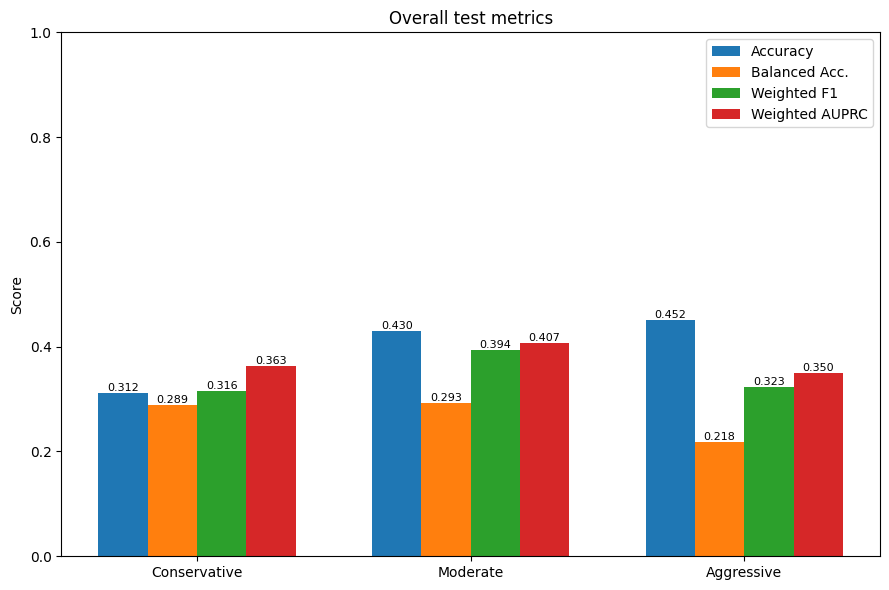

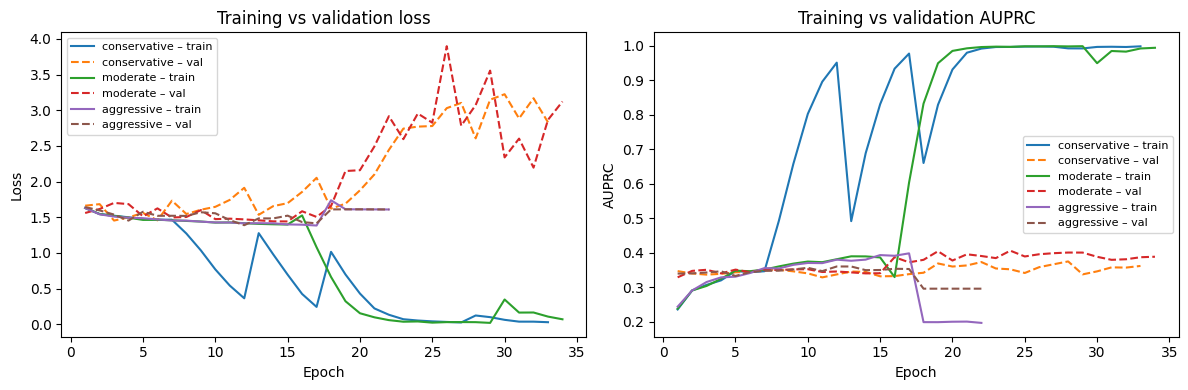

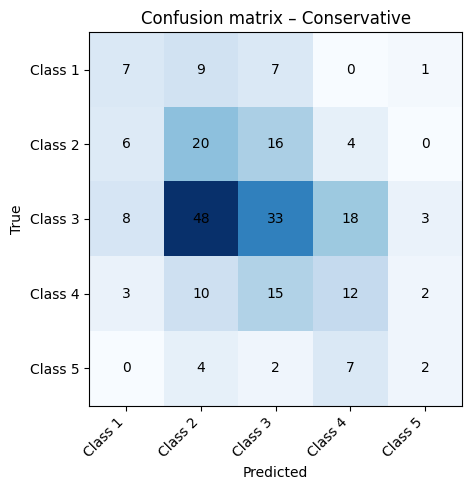

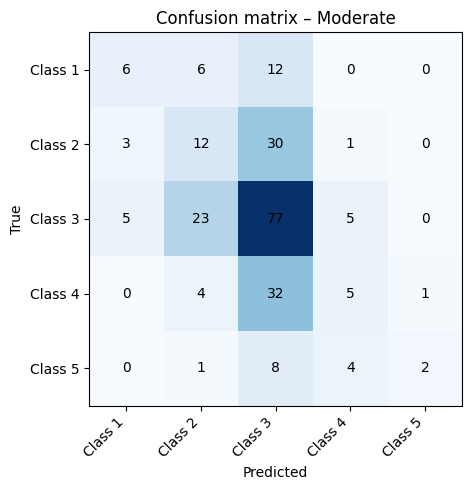

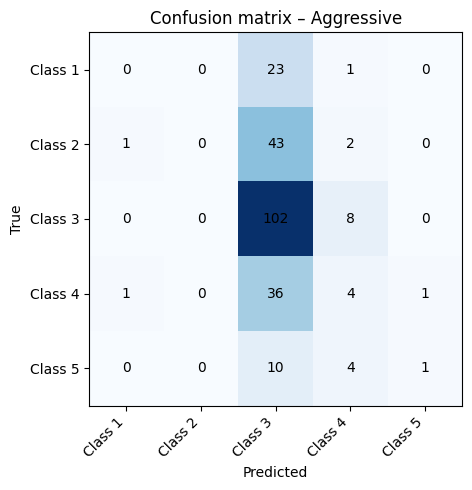

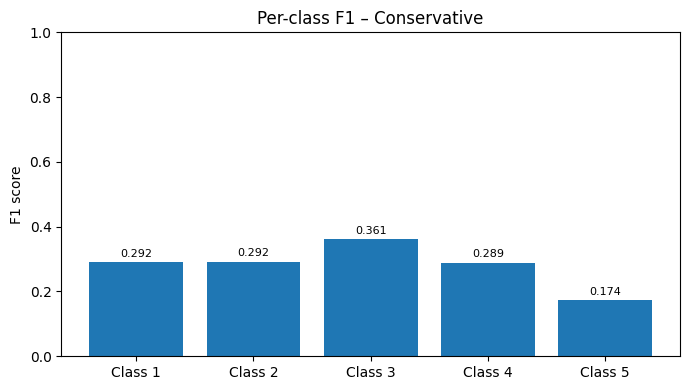

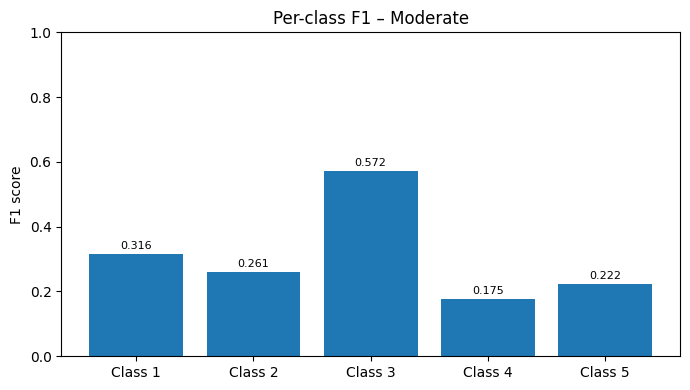

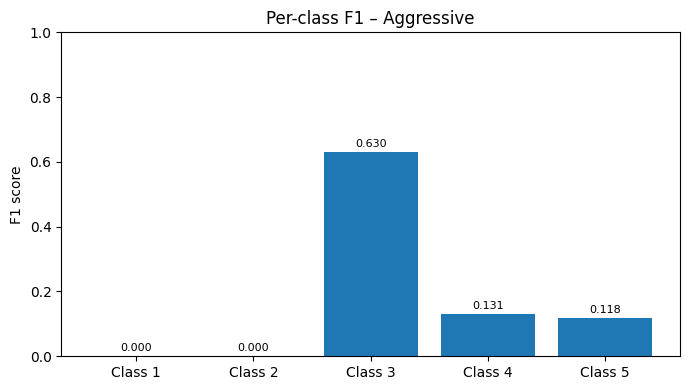

In [ ]:
evaluate_and_plot_full(results_5, X_test_5, y_test_5)

## Full 2

### Training

In [ ]:
results_2 = {}
for name, params in modes.items():
    print(f"\n########## RUNNING {name.upper()} MODE ##########")
    model, history = train_multi_stage(
        X_train_2, y_train_2, X_val_2, y_val_2,
        head_layers=[128, 2],
        batch_size=16,
        num_class= 2,
        epochs_list=params['epochs_list'],
        ft_initial_lr=params['ft_initial_lr'],
        ft_final_lr=params['ft_final_lr'],
        unfreeze_pcts=params['unfreeze_pcts'],
        mode_type = name
    )
    results_2[name] = {'model': model, 'history': history}


########## RUNNING CONSERVATIVE MODE ##########

=== Stage 1: Training head only (lr=0.001) ===
Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUPRC: 0.6471 - accuracy: 0.6250 - loss: 0.7118 — val_balanced_accuracy: 0.5270 — val_f1_score: 0.3323 — val_weighted_auprc: 0.6639

Epoch 1: val_weighted_auprc improved from -inf to 0.66388, saving model to best_model_per_stage_2.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 181ms/step - AUPRC: 0.6475 - accuracy: 0.6253 - loss: 0.7112 - val_AUPRC: 0.3872 - val_accuracy: 0.3544 - val_loss: 0.9830 - val_balanced_accuracy: 0.5270 - val_f1_score: 0.3323 - val_weighted_auprc: 0.6639
Epoch 2/20
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUPRC: 0.8169 - accuracy: 0.7436 - loss: 0.5200 — val_balanced_accuracy: 0.5031 — val_f1_score: 0.6605 — val_weighted_auprc: 0.6710

Epoch 2: val_weighted_auprc improved from 0.66388 to 0.67098, saving model to best_model_per_stage_2.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - AUPRC: 0.8169 - accuracy: 0.7437

E0000 00:00:1746698988.420118      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746698988.613419      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - AUPRC: 0.8999 - accuracy: 0.8167 - loss: 0.4033 — val_balanced_accuracy: 0.5124 — val_f1_score: 0.6721 — val_weighted_auprc: 0.7186

Epoch 1: val_weighted_auprc improved from 0.69846 to 0.71859, saving model to best_model_per_stage_2.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 244ms/step - AUPRC: 0.8999 - accuracy: 0.8166 - loss: 0.4034 - val_AUPRC: 0.7855 - val_accuracy: 0.7511 - val_loss: 0.5588 - val_balanced_accuracy: 0.5124 - val_f1_score: 0.6721 - val_weighted_auprc: 0.7186 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.8125000000000004e-05.
Epoch 2/25
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - AUPRC: 0.9248 - accuracy: 0.8493 - loss: 0.3482 — val_balanced_accuracy: 0.5180 — val_f1_score: 0.6771 — val_weighted_auprc: 0.7150

Epoch 2: val_weighted_auprc did not improve from 0.71859
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - AUPRC: 0.9248 - accuracy: 0.8492 - loss: 0.3482 - val_AUPRC: 0.7766 - val_ac

### Evaluation

## Nodule 5


### Training

In [ ]:
results_5 = {}
for name, params in modes.items():
    print(f"\n########## RUNNING {name.upper()} MODE ##########")
    model, history = train_multi_stage(
        X_train_5, y_train_5, X_val_5, y_val_5,
        head_layers=[5],
        batch_size=32,
        num_class= 5,
        epochs_list=params['epochs_list'],
        ft_initial_lr=params['ft_initial_lr'],
        ft_final_lr=params['ft_final_lr'],
        unfreeze_pcts=params['unfreeze_pcts'],
        mode_type = name
    )
    results_5[name] = {'model': model, 'history': history}


########## RUNNING CONSERVATIVE MODE ##########


I0000 00:00:1746637479.237342      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

=== Stage 1: Training head only (lr=0.001) ===
Epoch 1/20


I0000 00:00:1746637505.009211      61 service.cc:148] XLA service 0x7cb8b8002730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746637505.010620      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746637506.497740      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/137 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - AUPRC: 0.1807 - accuracy: 0.1562 - loss: 2.6786 

I0000 00:00:1746637511.250398      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUPRC: 0.2158 - accuracy: 0.2174 - loss: 1.8889 — val_balanced_accuracy: 0.4171 — val_f1_score: 0.3531 — val_weighted_auprc: 0.4312

Epoch 1: val_weighted_auprc improved from -inf to 0.43121, saving model to best_model_per_stage_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 243ms/step - AUPRC: 0.2159 - accuracy: 0.2177 - loss: 1.8874 - val_AUPRC: 0.3464 - val_accuracy: 0.3671 - val_loss: 1.4689 - val_balanced_accuracy: 0.4171 - val_f1_score: 0.3531 - val_weighted_auprc: 0.4312
Epoch 2/20
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUPRC: 0.3408 - accuracy: 0.3440 - loss: 1.4887 — val_balanced_accuracy: 0.4457 — val_f1_score: 0.3364 — val_weighted_auprc: 0.4642

Epoch 2: val_weighted_auprc improved from 0.43121 to 0.46423, saving model to best_model_per_stage_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - AUPRC: 0.3410 - accuracy: 0.3442 - loss: 1.4884 - val_AUPRC: 0.3554 - val_accuracy: 0.3460 - val_loss: 1.4289 - val_balanced_accuracy: 0.44

E0000 00:00:1746637732.872041      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746637733.066494      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746637733.267421      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746637733.443850      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUPRC: 0.5307 - accuracy: 0.4818 - loss: 1.2149

E0000 00:00:1746637762.246705      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746637762.422443      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746637762.659329      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746637762.853760      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - AUPRC: 0.5310 - accuracy: 0.4820 - loss: 1.2145 — val_balanced_accuracy: 0.5693 — val_f1_score: 0.5648 — val_weighted_auprc: 0.5711

Epoch 1: val_weighted_auprc improved from 0.52469 to 0.57113, saving model to best_model_per_stage_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 355ms/step - AUPRC: 0.5312 - accuracy: 0.4822 - loss: 1.2141 - val_AUPRC: 0.5869 - val_accuracy: 0.5654 - val_loss: 1.1000 - val_balanced_accuracy: 0.5693 - val_f1_score: 0.5648 - val_weighted_auprc: 0.5711 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.8125000000000004e-05.
Epoch 2/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUPRC: 0.6469 - accuracy: 0.5852 - loss: 1.0203 — val_balanced_accuracy: 0.5549 — val_f1_score: 0.5408 — val_weighted_auprc: 0.5719

Epoch 2: val_weighted_auprc improved from 0.57113 to 0.57194, saving model to best_model_per_stage_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - AUPRC: 0.6471 - accuracy

### Evaluation

,Accuracy,Balanced_accuracy,Weighted_F1,Weighted_AUPRC
Mode,,,,
Conservative,0.5654,0.4923,0.5534,0.5493
Moderate,0.4599,0.4406,0.4596,0.5402
Aggressive,0.4768,0.4968,0.4790,0.4748


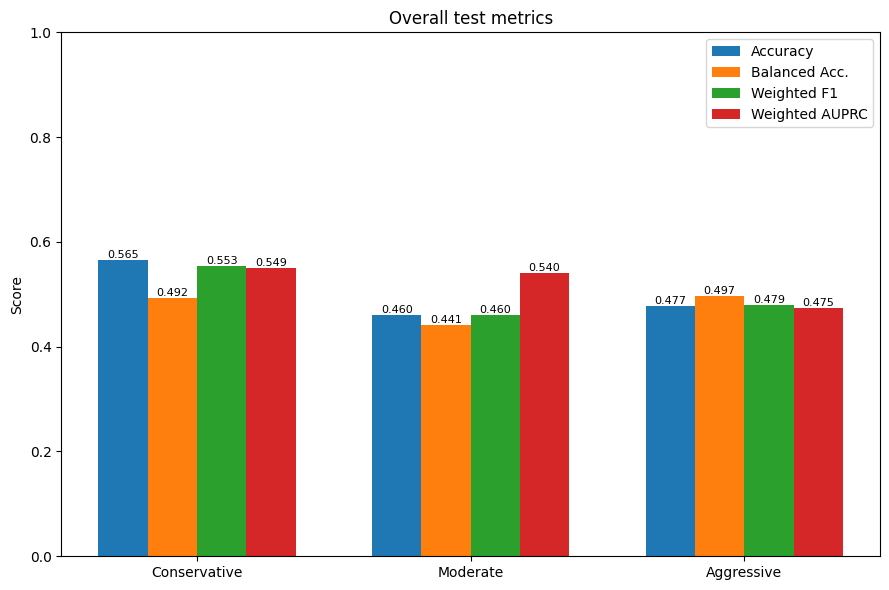

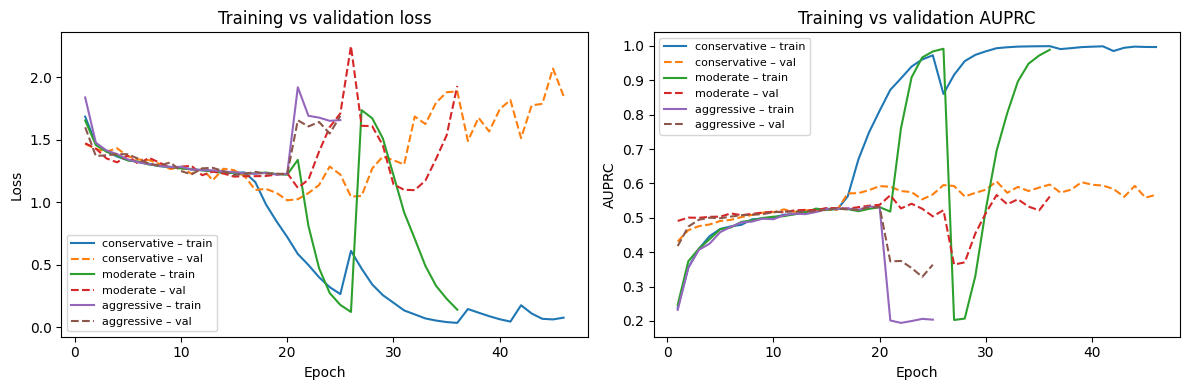

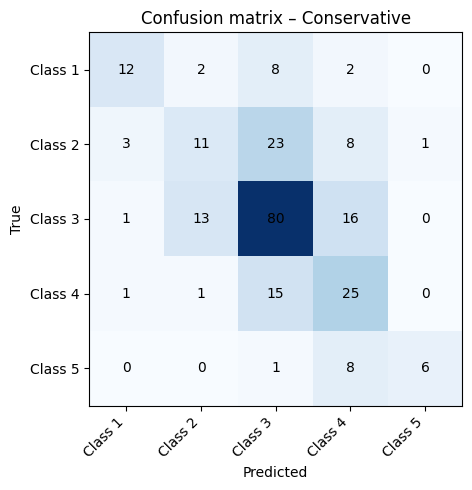

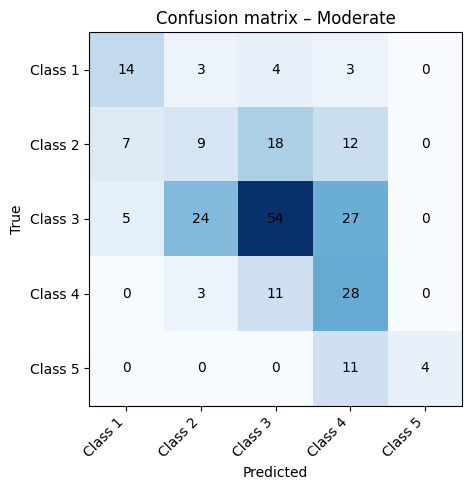

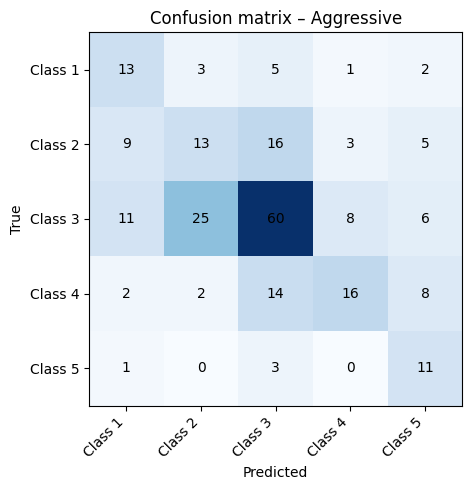

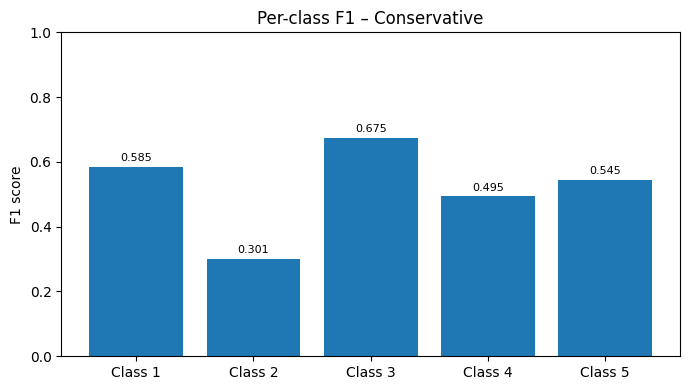

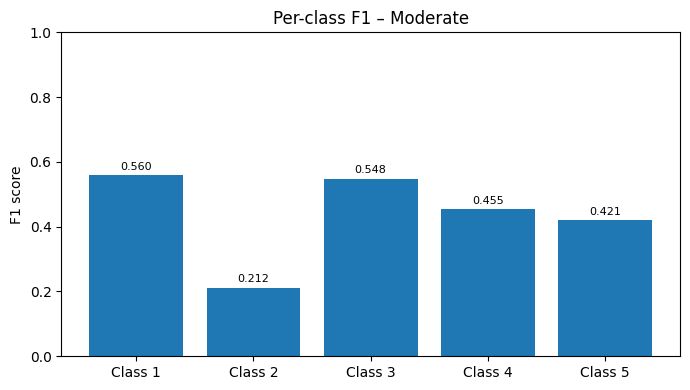

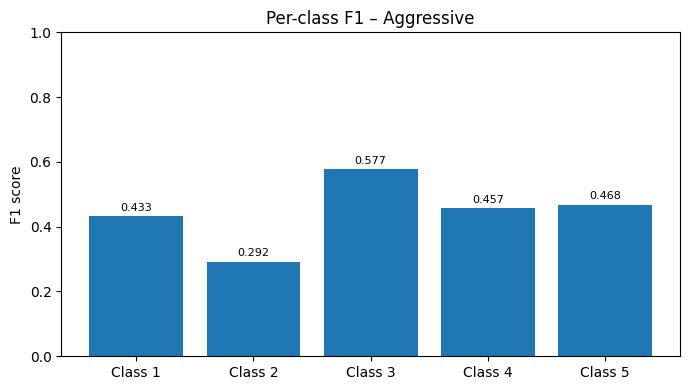

In [ ]:
evaluate_and_plot_full(results_5, X_test_5, y_test_5)

## Nodule 2

### Training

In [ ]:
results_2 = {}
for name, params in modes.items():
    print(f"\n########## RUNNING {name.upper()} MODE ##########")
    model, history = train_multi_stage(
        X_train_2, y_train_2, X_val_2, y_val_2,
        head_layers=[2],
        batch_size=32,
        num_class= 2,
        epochs_list=params['epochs_list'],
        ft_initial_lr=params['ft_initial_lr'],
        ft_final_lr=params['ft_final_lr'],
        unfreeze_pcts=params['unfreeze_pcts'],
        mode_type = name
    )
    results_2[name] = {'model': model, 'history': history}


########## RUNNING CONSERVATIVE MODE ##########

=== Stage 1: Training head only (lr=0.001) ===
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - AUPRC: 0.5014 - accuracy: 0.4900 - loss: 1.3104 — val_balanced_accuracy: 0.6991 — val_f1_score: 0.7466 — val_weighted_auprc: 0.8066

Epoch 1: val_weighted_auprc improved from -inf to 0.80659, saving model to best_model_per_stage_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 353ms/step - AUPRC: 0.5015 - accuracy: 0.4902 - loss: 1.3073 - val_AUPRC: 0.7574 - val_accuracy: 0.7342 - val_loss: 0.6359 - val_balanced_accuracy: 0.6991 - val_f1_score: 0.7466 - val_weighted_auprc: 0.8066
Epoch 2/20
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUPRC: 0.6939 - accuracy: 0.6528 - loss: 0.6296 — val_balanced_accuracy: 0.6813 — val_f1_score: 0.7817 — val_weighted_auprc: 0.8038

Epoch 2: val_weighted_auprc did not improve from 0.80659
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - AUPRC: 0.6948 - accuracy: 0.6534 - loss: 0.6291 - val_AUPRC: 0.8312 - val_accuracy: 0.789

E0000 00:00:1746640376.103205      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746640376.297861      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746640376.484621      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746640376.662814      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - AUPRC: 0.7905 - accuracy: 0.7248 - loss: 0.5446 — val_balanced_accuracy: 0.7225 — val_f1_score: 0.7102 — val_weighted_auprc: 0.8359

Epoch 1: val_weighted_auprc improved from 0.80659 to 0.83585, saving model to best_model_per_stage_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 471ms/step - AUPRC: 0.7911 - accuracy: 0.7253 - loss: 0.5439 - val_AUPRC: 0.7307 - val_accuracy: 0.6878 - val_loss: 0.6083 - val_balanced_accuracy: 0.7225 - val_f1_score: 0.7102 - val_weighted_auprc: 0.8359 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.8125000000000004e-05.
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - AUPRC: 0.9051 - accuracy: 0.8458 - loss: 0.3785 — val_balanced_accuracy: 0.7750 — val_f1_score: 0.8322 — val_weighted_auprc: 0.8679

Epoch 2: val_weighted_auprc improved from 0.83585 to 0.86791, saving model to best_model_per_stage_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - AUPRC: 0.9054 - accuracy: 0.8461

### Evaluation

,Accuracy,Balanced_accuracy,Weighted_F1,Weighted_AUPRC
Mode,,,,
Conservative,0.8228,0.7575,0.8228,0.8769
Moderate,0.8397,0.7566,0.8354,0.8639
Aggressive,0.8523,0.7469,0.8427,0.8661


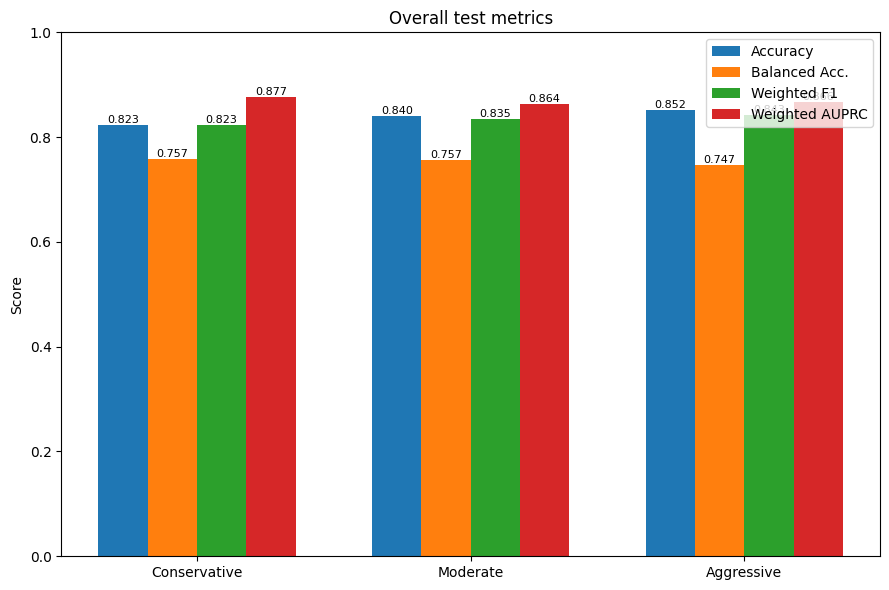

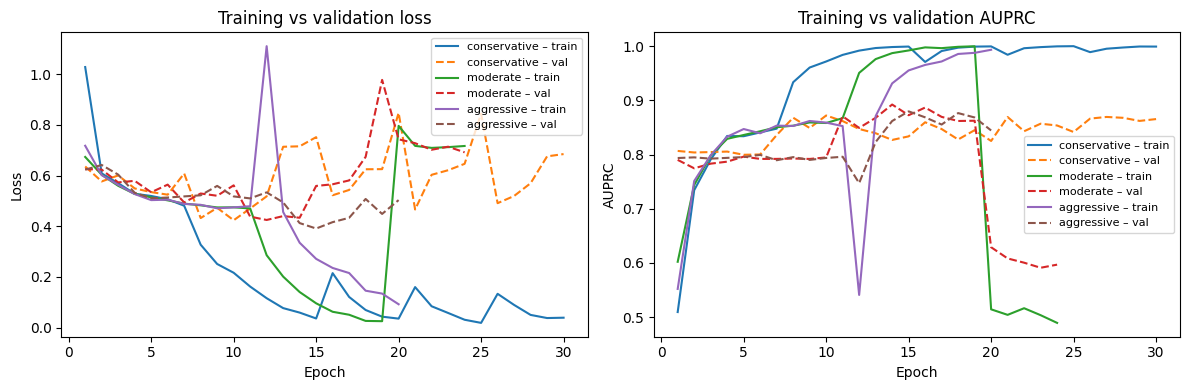

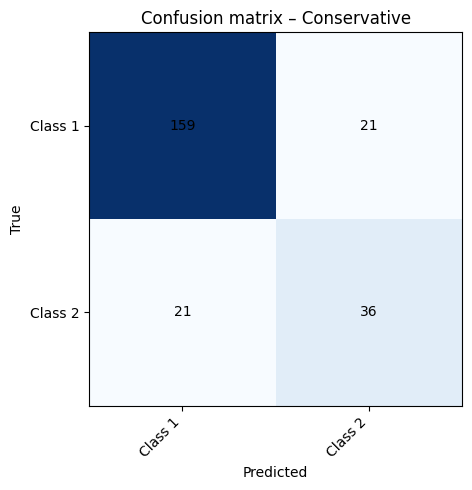

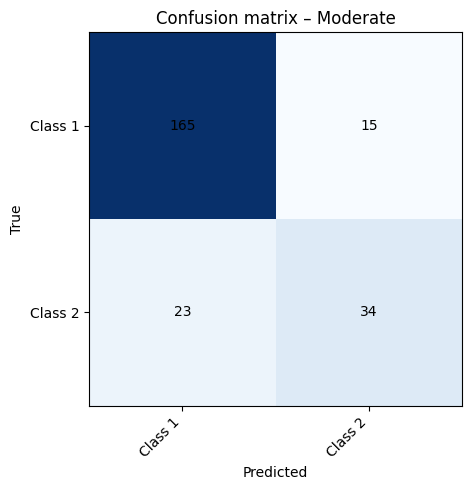

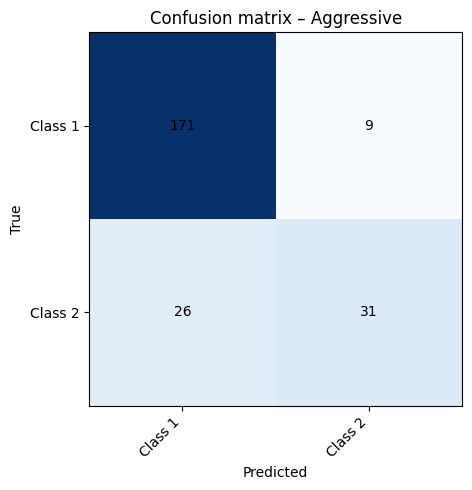

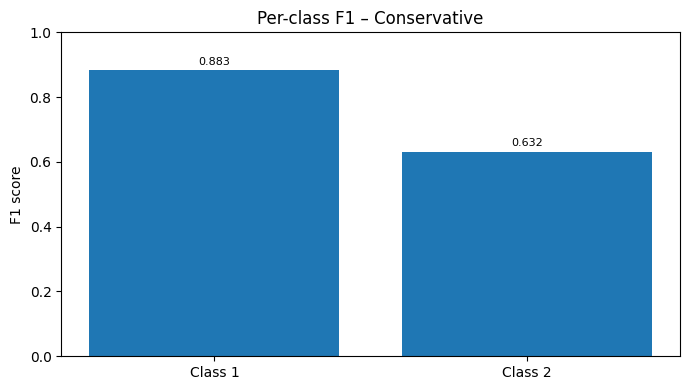

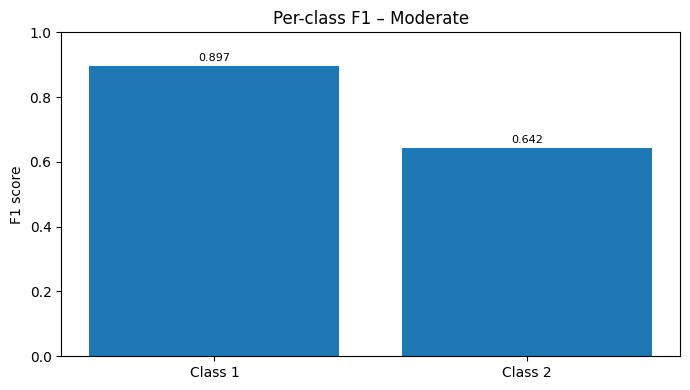

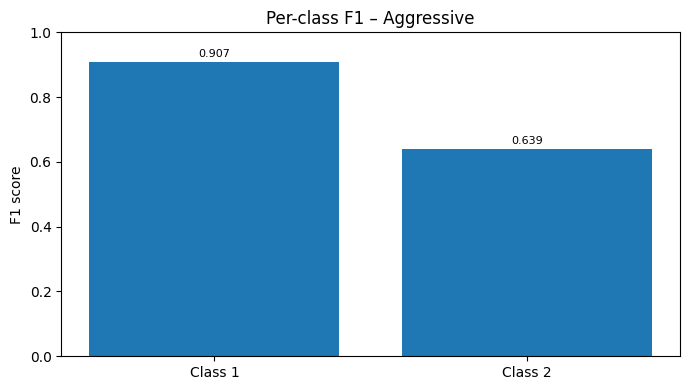

In [ ]:
evaluate_and_plot_full(results_2, X_test_2, y_test_2)

,Accuracy,Balanced_accuracy,Weighted_F1,Weighted_AUPRC
Mode,,,,
Conservative,0.7764,0.6190,0.7522,0.7688
Moderate,0.7848,0.6785,0.7782,0.8050
Aggressive,0.6498,0.5417,0.6564,0.6826


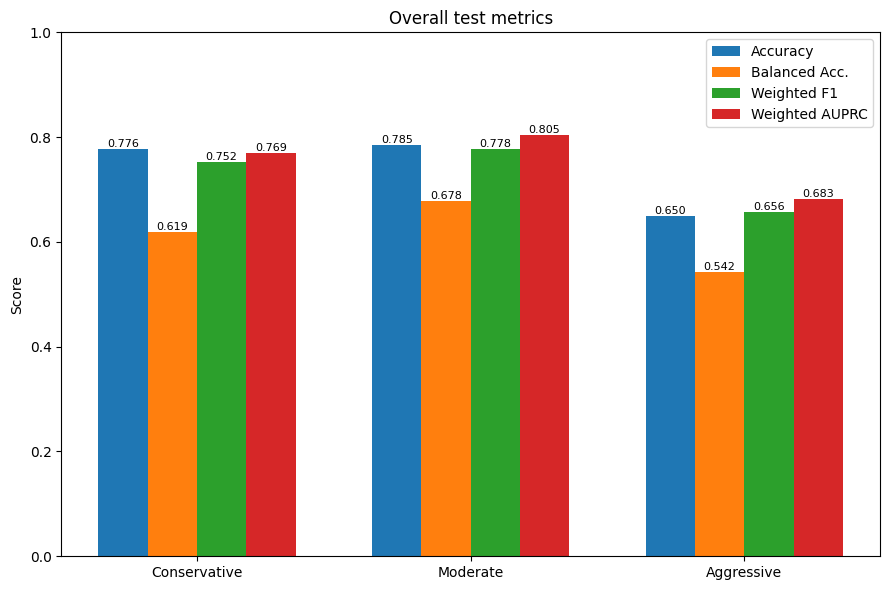

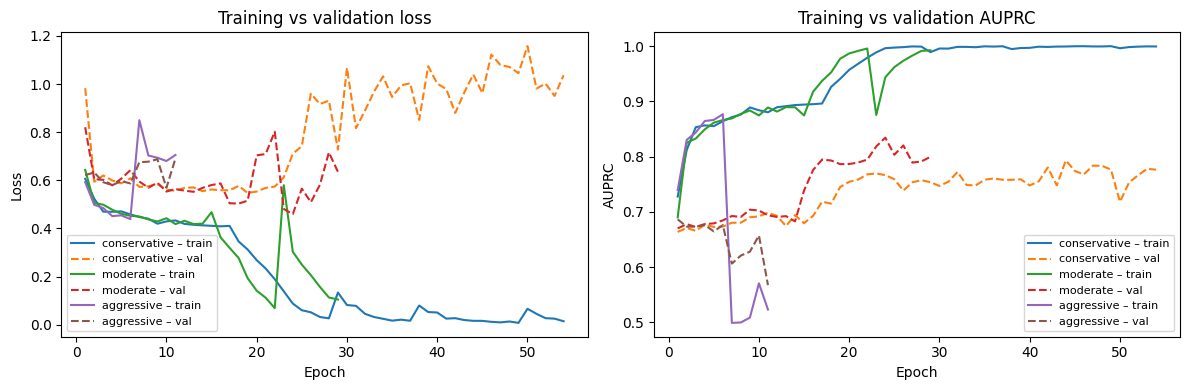

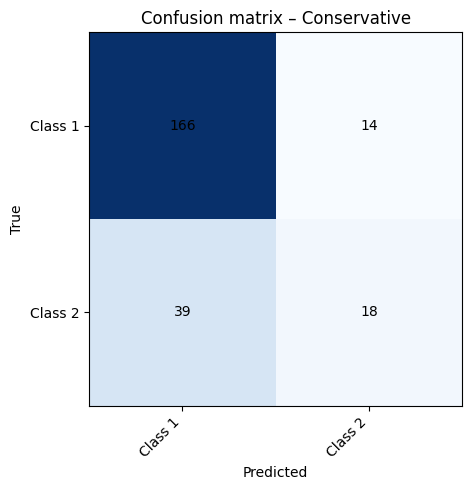

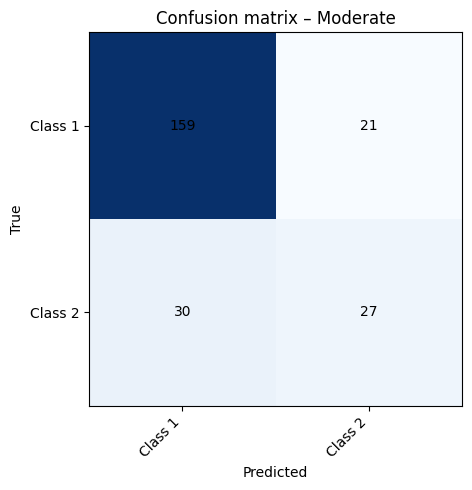

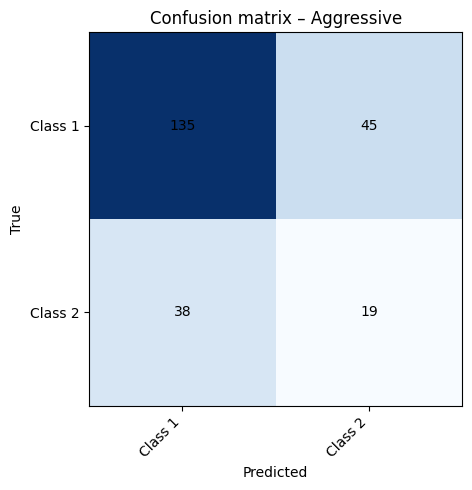

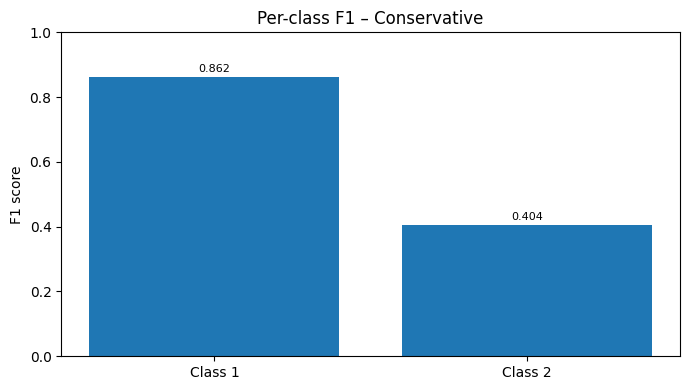

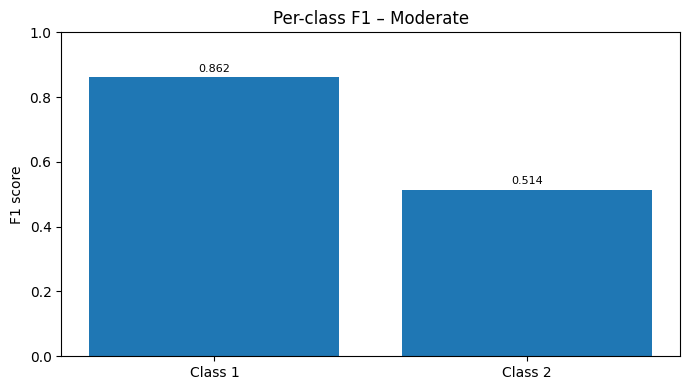

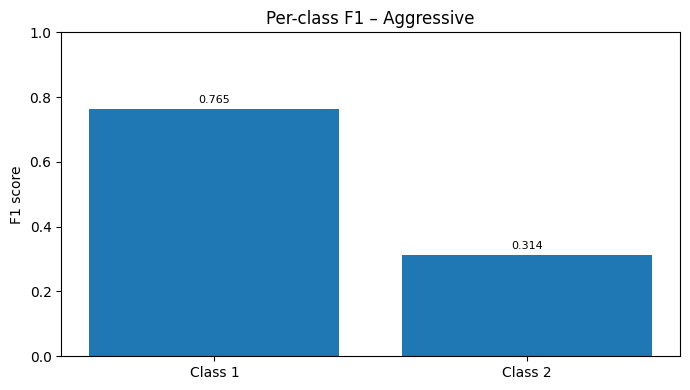

In [ ]:
evaluate_and_plot_full(results_2, X_test_2, y_test_2)